#**Predictive Analytics: Harga Rumah**

Proyek ini bertujuan untuk membangun model prediksi harga rumah berdasarkan berbagai fitur properti seperti luas bangunan, jumlah kamar, keberadaan AC, dan fasilitas lainnya.


In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
sns.set(style='darkgrid',font_scale=1.5)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Data Preparation
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Modeling eval
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Data Loading

In [159]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harishkumardatalab/housing-price-prediction")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/housing-price-prediction


In [160]:
# loding data
data = pd.read_csv(path + '/Housing.csv')

# Membaca 5 baris data
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


# EDA

## EDA - Deskripsi Variabel

In [161]:
# mengecek informasi pada dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


**Dataset**

- Dataset memiliki 545 sample dengan 13 fitur
- Dataset memiliki 6 fitur numerik (int64) yaitu `price`, `area`, `bedrooms`, `bathrooms`, `stories` dan `parking`
- Dataset memiliki 7 fitur kategorikal (object) yaitu `mainroad`, `guestroom`, `basement`, `hotwaterheating`, `aircondition`, `prefarea`, `furnishingstatus`


**Variabel dalam Dataset**
1. `price`:	Harga rumah.
2. `area`: Luas rumah dalam satuan kaki persegi.
3. `bedrooms`: Jumlah kamar tidur.
4. `bathrooms`:	Jumlah kamar mandi.
5. `stories`:	Jumlah lantai (tingkat) rumah.
6. `mainroad`: Apakah rumah terhubung ke jalan utama (Yes / No).
7. `guestroom`: Apakah memiliki kamar tamu (Yes / No).
8. `basement`: Apakah memiliki ruang bawah tanah (Yes / No).
8. `hotwaterheating`:	Apakah memiliki pemanas air (Yes / No).
9. `airconditioning`:	Apakah memiliki AC (Yes / No).
10. `parking`: Jumlah tempat parkir.
11. `prefarea`: Apakah berada di area yang diinginkan (Yes / No).
12. `furnishingstatus`: Status perabotan rumah (furnished, semi-furnished, unfurnished).



In [162]:
data.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


**Insight Statistik**
- Harga rumah sangat bervariasi, dari 1.75 juta hingga 13.3 juta, dengan rata-rata sekitar 4.77 juta.

- Luas bangunan memiliki sebaran yang cukup lebar, dari rumah kecil 1.650 sqft hingga rumah besar 16.200 sqft.

- Mayoritas rumah memiliki 2-3 kamar tidur, 1 kamar mandi, dan 1-2 lantai.

- Sebagian besar rumah tidak memiliki garasi, terlihat dari median dan Q1 untuk parking adalah 0.

- Nilai standard deviation yang tinggi pada price dan area menunjukkan adanya variasi atau kemungkinan outlier yang signifikan.

## EDA - Data Cleaning

In [163]:
# Cek missing value
data.isnull().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


In [164]:
# Mengecek duplikasi data
data.duplicated().sum()

np.int64(0)

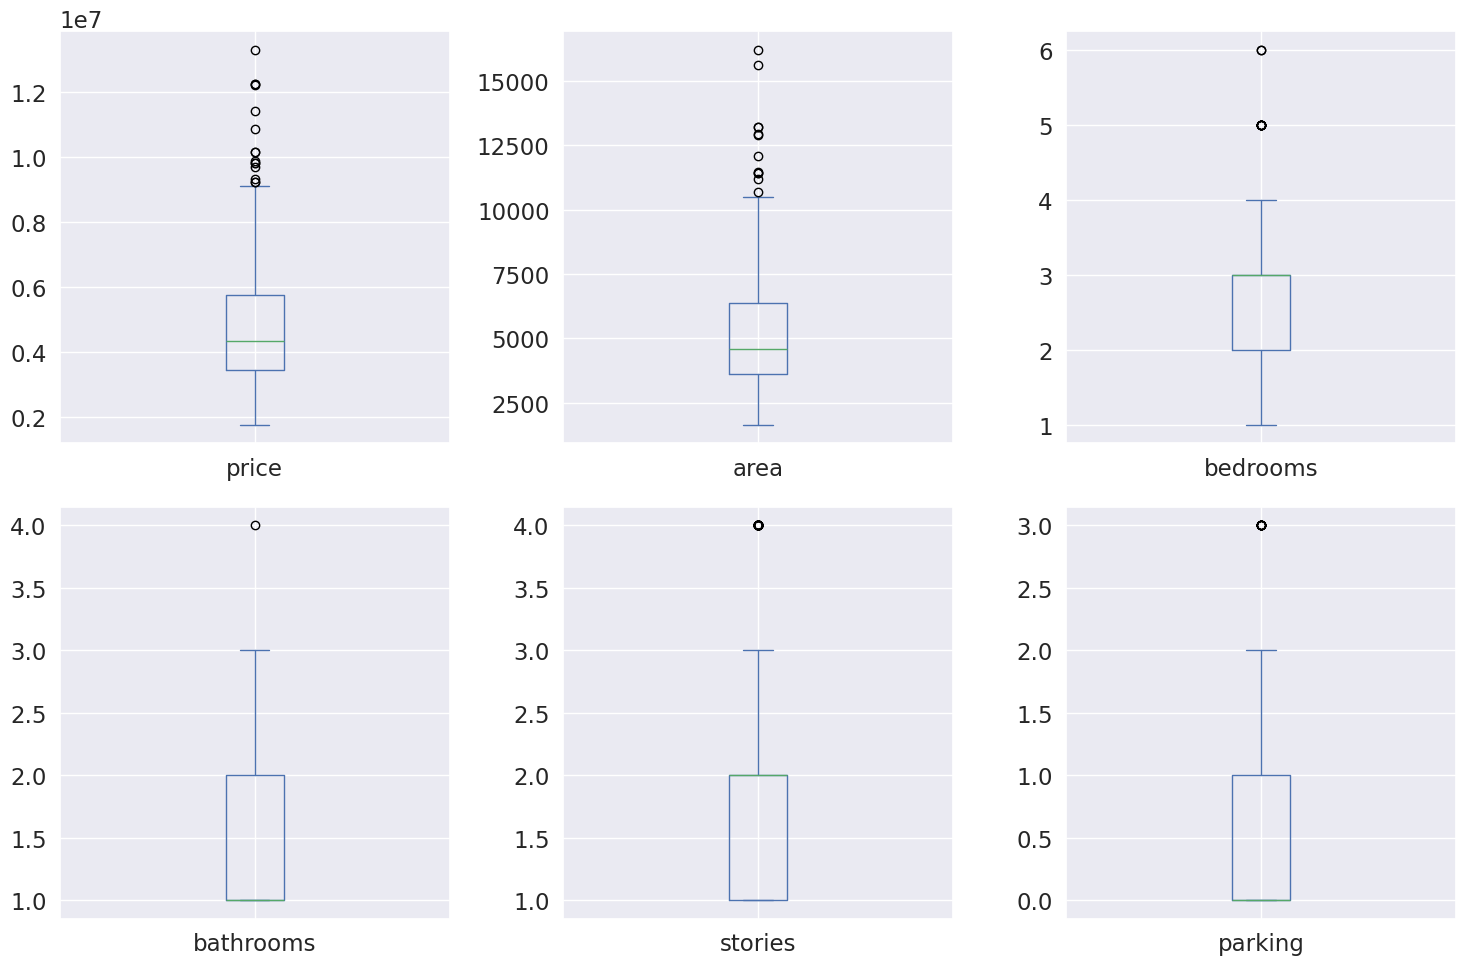

In [165]:
# Mengecek outlier data numerik
# Mengubah layout agar sesuai dengan jumlah kolom pada DataFrame
data.plot(kind='box', subplots=True, layout=(2,3), figsize=(15,10))
plt.tight_layout()
plt.show()

In [166]:
# Tabel outlier

# Calculate outliers using IQR
numeric_cols = data.select_dtypes(include=np.number).columns
outlier_data = []

for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]

    outlier_data.append({
        'Feature': col,
        'Lower Bound (IQR)': lower_bound,
        'Upper Bound (IQR)': upper_bound,
        'Number of Outliers': len(outliers),
        'Percentage of Outliers': (len(outliers) / len(data)) * 100
    })

outlier_df = pd.DataFrame(outlier_data)
print("Outlier Analysis using IQR:")
outlier_df


Outlier Analysis using IQR:


,Feature,Lower Bound (IQR),Upper Bound (IQR),Number of Outliers,Percentage of Outliers
0,price,-35000.0,9205000.0,15,2.752294
1,area,-540.0,10500.0,12,2.201835
2,bedrooms,0.5,4.5,12,2.201835
3,bathrooms,-0.5,3.5,1,0.183486
4,stories,-0.5,3.5,41,7.522936
5,parking,-1.5,2.5,12,2.201835


**Outlier:**
- Outlier pada `stories` (jumlah lantai) merupakan yang terbanyak (41 rumah). Data yang dianggap outlier adalah rumah dengan 4 lantai.

- Outlier pada `price` sebagian besar merupakan rumah dengan harga di atas 9,205,000. Namun, rumah-rumah ini juga cenderung memiliki luas besar, jumlah lantai lebih tinggi, dan fasilitas lengkap (AC, kamar tamu, lokasi premium).

- Outlier pada `area` umumnya rumah yang sangat besar (> 10.500 sqft).

- Tidak ditemukan outlier negatif yang tidak realistis (contohnya harga rumah negatif).

In [167]:
# Mengecek data outlier stories
data[data['stories'] > 3.5]

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished
17,8960000,8500,3,2,4,yes,no,no,no,yes,2,no,furnished
26,8463000,6000,3,2,4,yes,yes,yes,no,yes,0,yes,semi-furnished
30,8400000,7475,3,2,4,yes,no,no,no,yes,2,no,unfurnished
31,8400000,7000,3,1,4,yes,no,no,no,yes,2,no,semi-furnished
35,8080940,7000,3,2,4,yes,no,no,no,yes,2,no,furnished
37,7980000,9000,4,2,4,yes,no,no,no,yes,2,no,furnished
38,7962500,6000,3,1,4,yes,yes,no,no,yes,2,no,unfurnished


In [168]:
# Mengecek data outlier price
data[data['price'] > 9205000]

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished
5,10850000,7500,3,3,1,yes,no,yes,no,yes,2,yes,semi-furnished
6,10150000,8580,4,3,4,yes,no,no,no,yes,2,yes,semi-furnished
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
8,9870000,8100,4,1,2,yes,yes,yes,no,yes,2,yes,furnished
9,9800000,5750,3,2,4,yes,yes,no,no,yes,1,yes,unfurnished


In [169]:
# Mengecek data outlier area
data[data['area'] > 10500]

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
7,10150000,16200,5,3,2,yes,no,no,no,no,0,no,unfurnished
10,9800000,13200,3,1,2,yes,no,yes,no,yes,2,yes,furnished
56,7343000,11440,4,1,2,yes,no,yes,no,no,1,yes,semi-furnished
64,7000000,11175,3,1,1,yes,no,yes,no,yes,1,yes,furnished
66,6930000,13200,2,1,1,yes,no,yes,yes,no,1,no,furnished
69,6790000,12090,4,2,2,yes,no,no,no,no,2,yes,furnished
125,5943000,15600,3,1,1,yes,no,no,no,yes,2,no,semi-furnished
129,5873000,11460,3,1,3,yes,no,no,no,no,2,yes,semi-furnished
186,5110000,11410,2,1,2,yes,no,no,no,no,0,yes,furnished
191,5040000,10700,3,1,2,yes,yes,yes,no,no,0,no,semi-furnished


**Kesimpulan**
- Dataset tidak memiliki nilai kosong ataupun nilai duplikat
- Pada `price`, nilai-nilai di atas 9.205.000 dianggap outlier. Namun, setelah ditinjau manual, data tersebut merepresentasikan properti dengan karakteristik premium seperti luas tanah yang besar, fasilitas lengkap (AC, basement, hot water, dan lainnya), serta lokasi strategis di jalan utama. Sehingga outlier ini bisa dianggap valid
- Pada outlier fitur `stories` dan `area` bisa dianggap data yang valid. Hal ini karena, rumah dengan 4 lantai atau area yang luas memiliki kelengkapan fasilitas yang mendukung (misalnya 3-4 kamar mandi, parkiran luas, dan harga tinggi).
- Begitu juga dengan outlier pada fitur lainnya, data tersebut masuk akal dengan mempertimbangkan nilai pada fitur yang lain.


## EDA - Univariate Analysis

In [170]:
# pembagian numerical features dan categorical features
numerical_features = ['price','area', 'bedrooms', 'bathrooms', 'stories', 'parking']
categorical_features = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

### Kategorikal


Fitur: mainroad
          jumlah sampel  persentase
mainroad                           
yes                 468        85.9
no                   77        14.1 



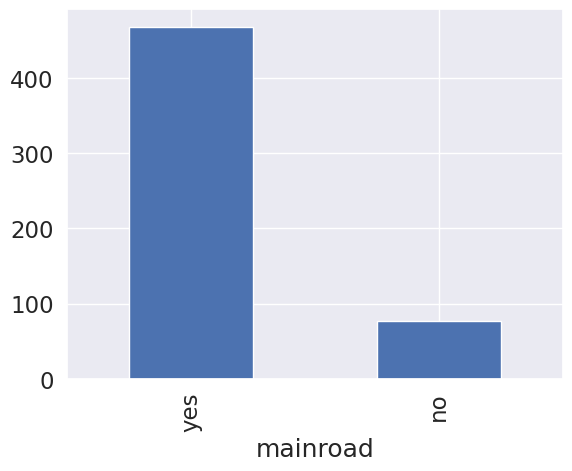

In [171]:
# Fitur mainroad

feature = categorical_features[0]
count = data[feature].value_counts()
percent = 100 * data[feature].value_counts(normalize=True)
df_summary = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})
print(f"\nFitur: {feature}")
print(df_summary, '\n')
count.plot(kind='bar')
plt.show()


Fitur: guestroom
           jumlah sampel  persentase
guestroom                           
no                   448        82.2
yes                   97        17.8


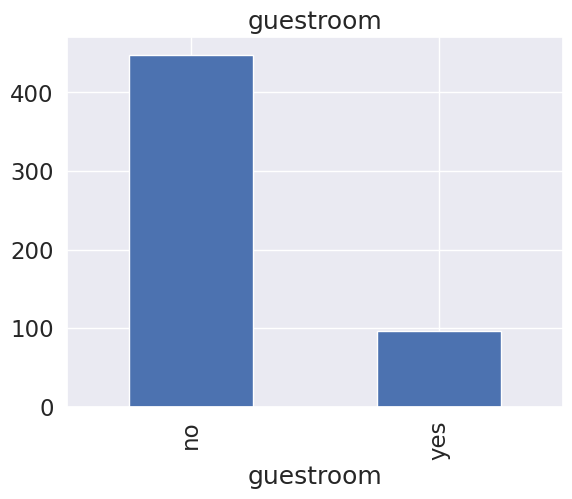

In [172]:
# Fitur guestroom

feature = categorical_features[1]
count = data[feature].value_counts()
percent = 100 * data[feature].value_counts(normalize=True)
df_summary = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})
print(f"\nFitur: {feature}")
print(df_summary)
count.plot(kind='bar', title=feature)
plt.show()


Fitur: basement
          jumlah sampel  persentase
basement                           
no                  354        65.0
yes                 191        35.0


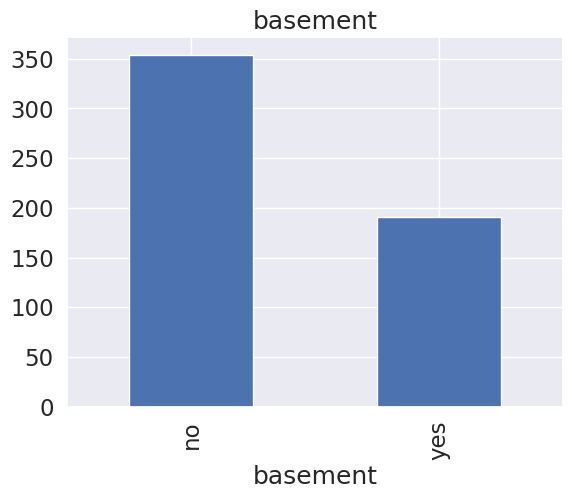

In [173]:
# Fitur basement

feature = categorical_features[2]
count = data[feature].value_counts()
percent = 100 * data[feature].value_counts(normalize=True)
df_summary = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})
print(f"\nFitur: {feature}")
print(df_summary)
count.plot(kind='bar', title=feature)
plt.show()


Fitur: hotwaterheating
                 jumlah sampel  persentase
hotwaterheating                           
no                         520        95.4
yes                         25         4.6


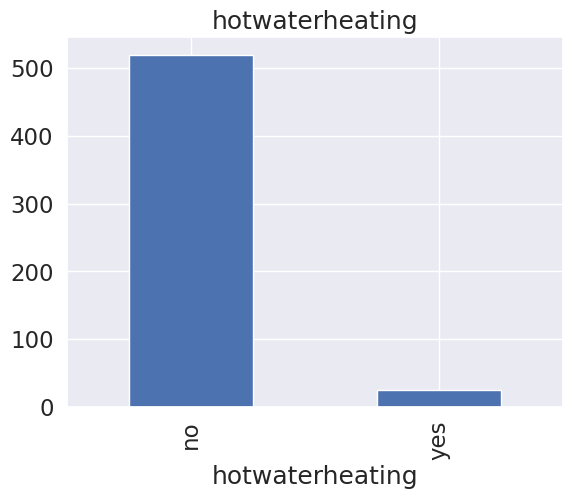

In [174]:
# Fitur hotwaterheating

feature = categorical_features[3]
count = data[feature].value_counts()
percent = 100 * data[feature].value_counts(normalize=True)
df_summary = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})
print(f"\nFitur: {feature}")
print(df_summary)
count.plot(kind='bar', title=feature)
plt.show()


Fitur: airconditioning
                 jumlah sampel  persentase
airconditioning                           
no                         373        68.4
yes                        172        31.6


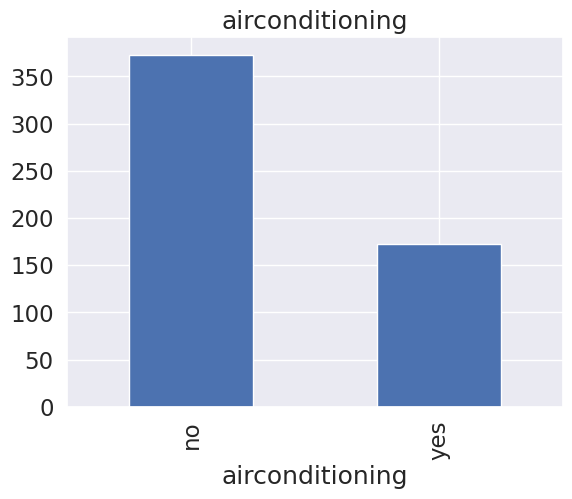

In [175]:
# Fitur airconditioning

feature = categorical_features[4]
count = data[feature].value_counts()
percent = 100 * data[feature].value_counts(normalize=True)
df_summary = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})
print(f"\nFitur: {feature}")
print(df_summary)
count.plot(kind='bar', title=feature)
plt.show()


Fitur: prefarea
          jumlah sampel  persentase
prefarea                           
no                  417        76.5
yes                 128        23.5


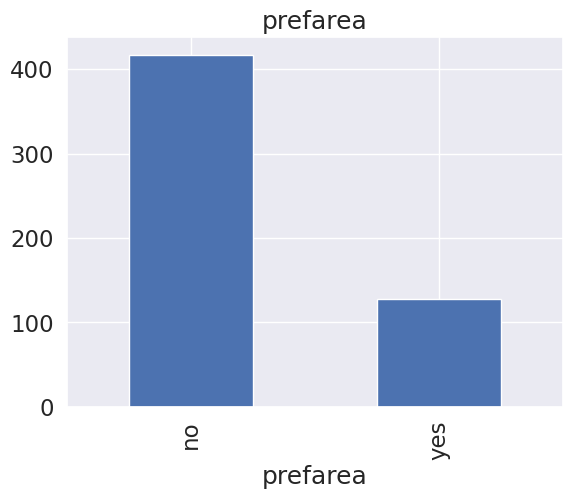

In [176]:
# Fitur prefarea

feature = categorical_features[5]
count = data[feature].value_counts()
percent = 100 * data[feature].value_counts(normalize=True)
df_summary = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})
print(f"\nFitur: {feature}")
print(df_summary)
count.plot(kind='bar', title=feature)
plt.show()


Fitur: furnishingstatus
                  jumlah sampel  persentase
furnishingstatus                           
semi-furnished              227        41.7
unfurnished                 178        32.7
furnished                   140        25.7


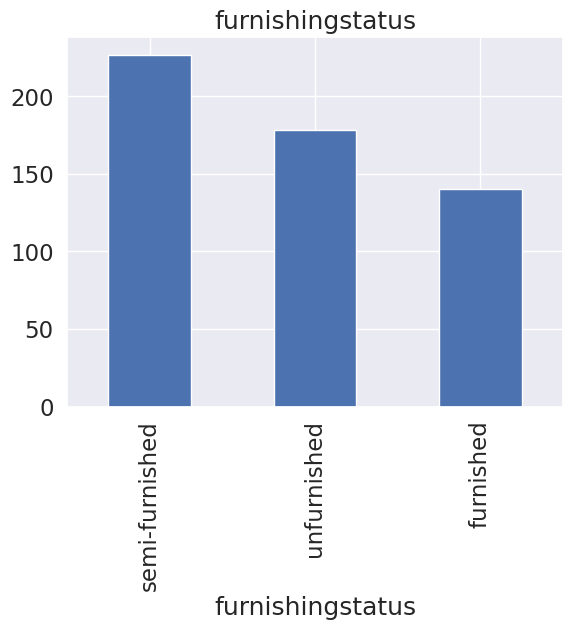

In [177]:
# Fitur furnishingstatus

feature = categorical_features[6]
count = data[feature].value_counts()
percent = 100 * data[feature].value_counts(normalize=True)
df_summary = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})
print(f"\nFitur: {feature}")
print(df_summary)
count.plot(kind='bar', title=feature)
plt.show()

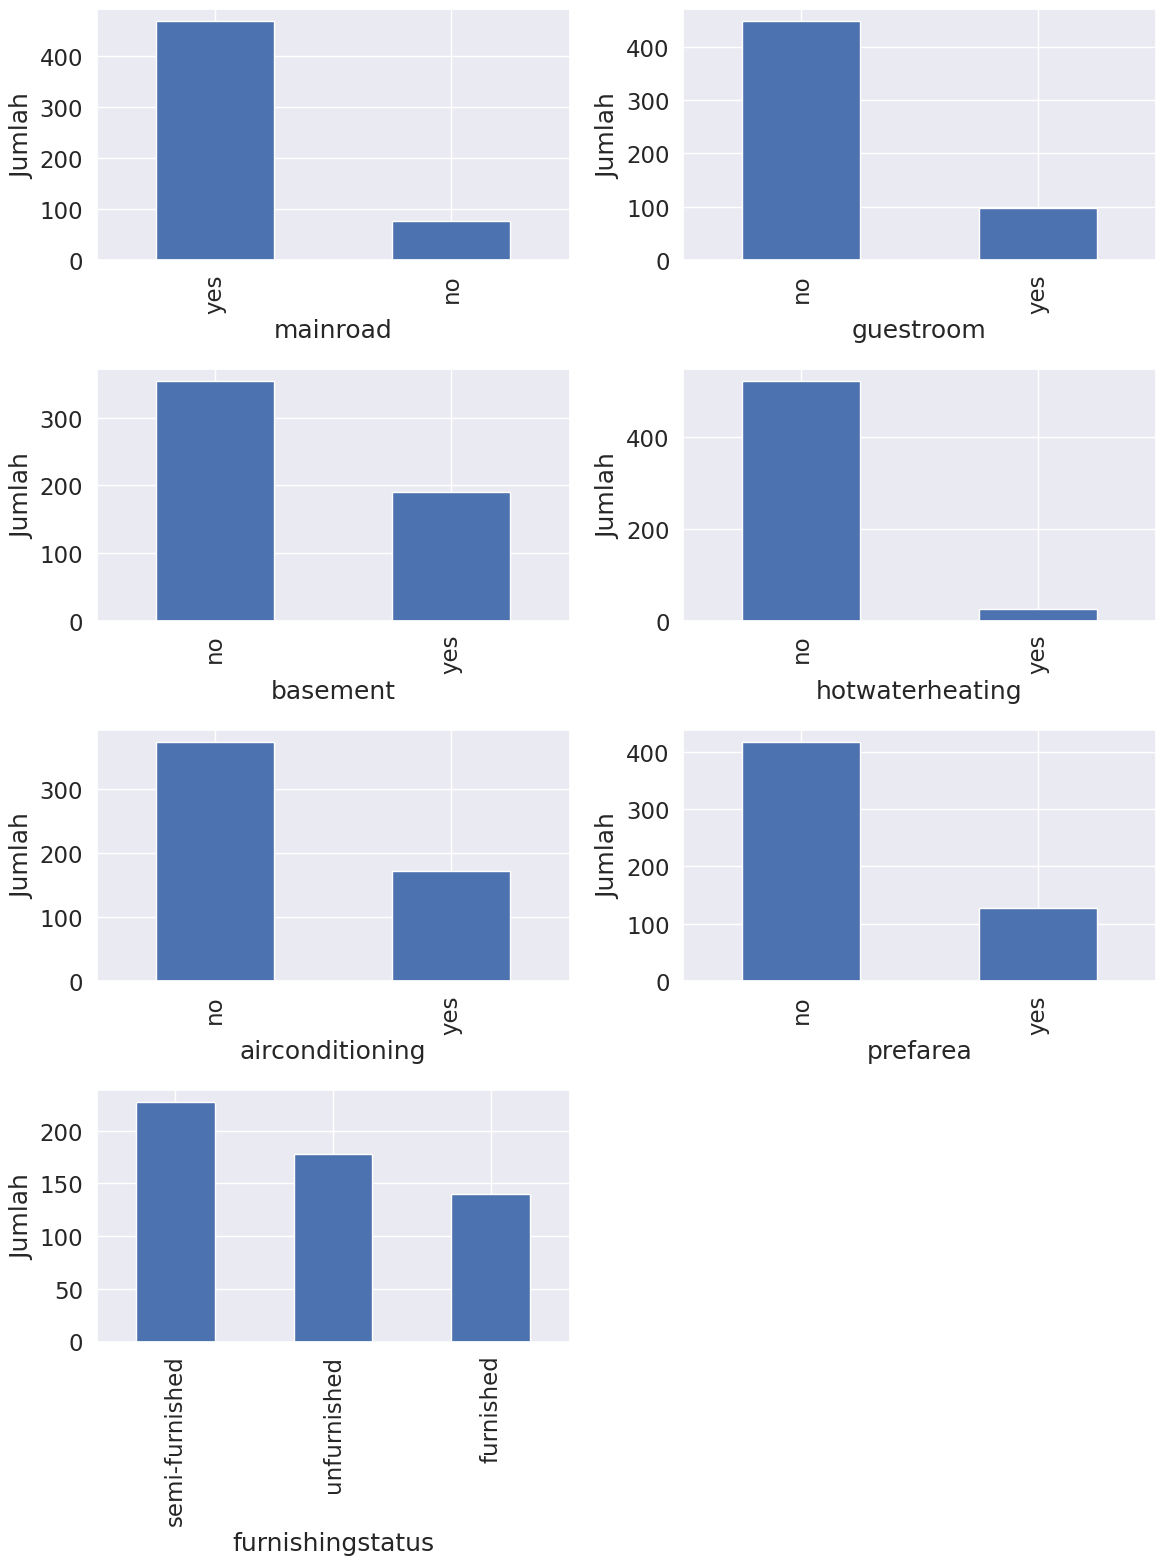

In [178]:
# univariate analysisis Fitur kategorikal
n_features = len(categorical_features)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(categorical_features):
    count = data[feature].value_counts()
    percent = 100 * data[feature].value_counts(normalize=True)
    df_summary = pd.DataFrame({'jumlah sampel': count, 'persentase': percent.round(1)})

    ax = axes[i]
    count.plot(kind='bar', ax=ax)
    ax.set_ylabel("Jumlah")
    ax.set_xlabel(feature)

# Jika jumlah plot tidak genap, hilangkan axis yang kosong
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



**Kesimpulan:**

1. `Mainroad` : Mayoritas rumah memiliki akses ke jalan utama (`yes`), menunjukkan bahwa aksesibilitas merupakan fitur umum dan penting teks dalam properti.

2. `Guestroom` :
   Sebagian besar rumah tidak memiliki kamar tamu, yang mungkin mencerminkan rumah-rumah dengan desain untuk keluarga kecil.

3. `Basement` :
   Lebih banyak rumah tanpa basement, menunjukkan bahwa keberadaan basement mungkin bukan fitur standar atau kebutuhan utama di lokasi dataset ini.

4. `Hotwaterheating` :
   Hampir semua rumah tidak memiliki pemanas air, mengindikasikan bahwa fitur ini cukup langka dan mungkin dianggap sebagai fasilitas mewah.

5. `Airconditioning` :
   Sebagian besar rumah tidak memiliki AC, namun jumlahnya masih cukup banyak (ada lebih dari 100 rumah yang memilikinya), menunjukkan variabilitas dalam kenyamanan rumah.

6. `Prefarea` :
   Mayoritas rumah tidak berada di area yang diutamakan, menandakan bahwa lokasi premium relatif lebih sedikit, yang bisa memengaruhi harga secara signifikan.

7. `Furnishingstatus` :
   Status perabotan rumah cukup seimbang, namun rumah `semi-furnished` mendominasi, diikuti oleh `unfurnished` dan `furnished`. Hal ini menunjukkan bahwa pasar properti cenderung menyediakan rumah dengan perlengkapan sebagian atau semi, yang fleksibel untuk pembeli.


### Numerik

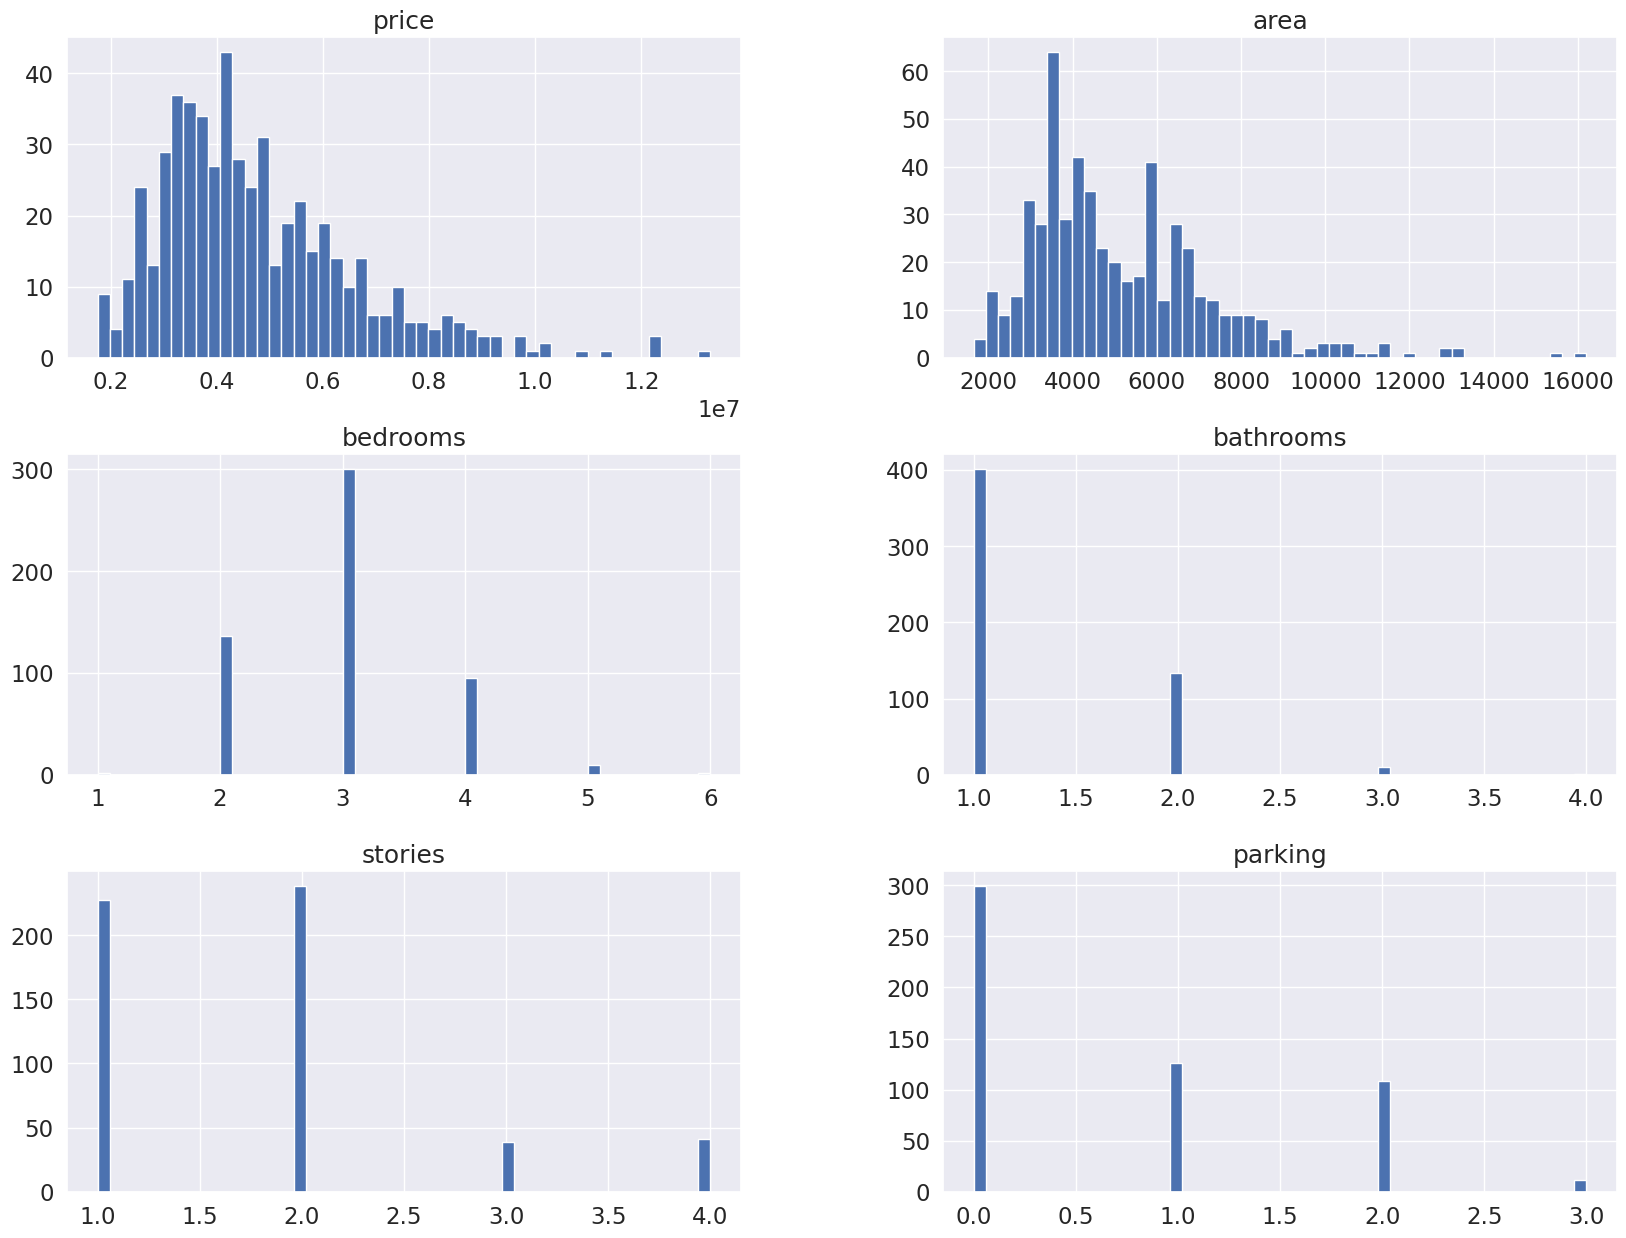

In [179]:
# Analisis Fitur Numerik
data[numerical_features].hist(bins=50, figsize=(20, 15))
plt.show()


**Kesimpulan:**
- Mayoritas rumah pada dataset ini memiliki karakteristik tipe keluarga standar dengan harga dan luas rumah yang cenderung di kisaran rendah hingga menengah.
- Distribusi harga dan luas rumah skewed ke kanan, menunjukkan adanya beberapa rumah dengan harga dan ukuran sangat tinggi sebagai outlier.
- Rumah dengan 3 kamar tidur dan 1 kamar mandi mendominasi, serta rumah bertingkat 1-2 paling umum. Kebanyakan rumah juga tidak memiliki area parkir, mencerminkan mayoritas rumah dengan tipe sederhana dan tidak mewah, dengan beberapa properti yang lebih besar dan mahal sebagai pengecualian.

## EDA - Multivariate Analysis

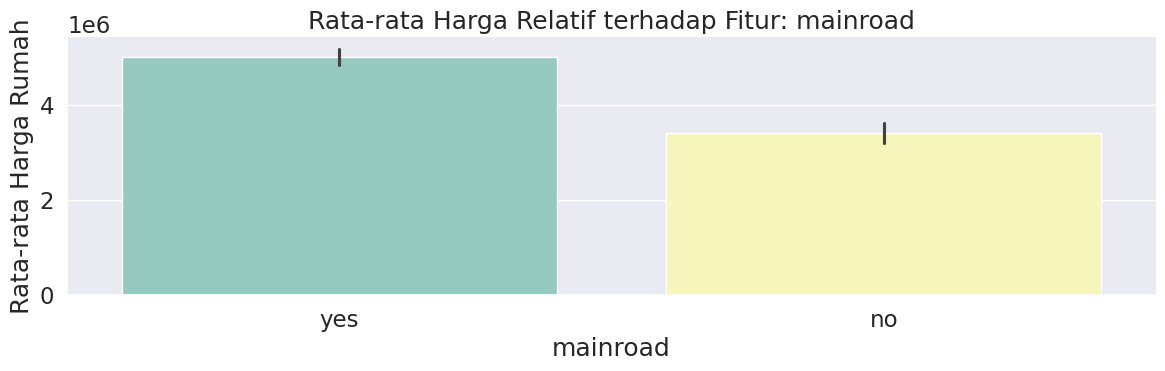

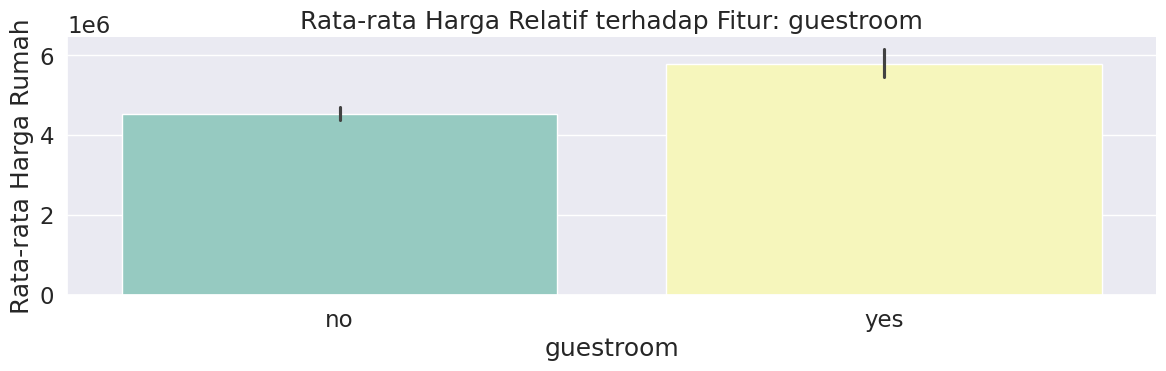

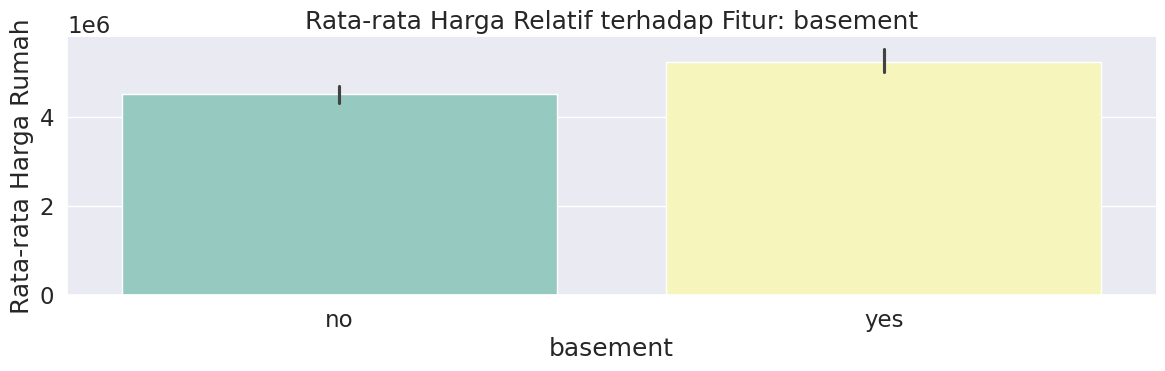

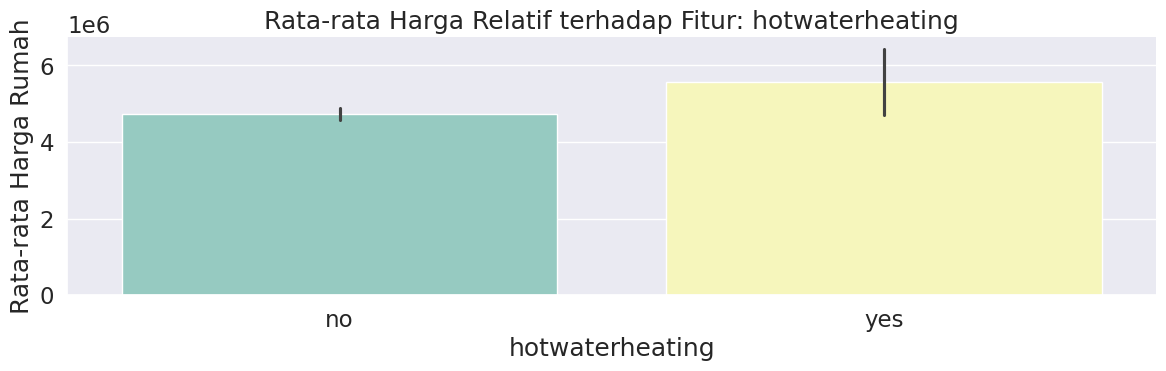

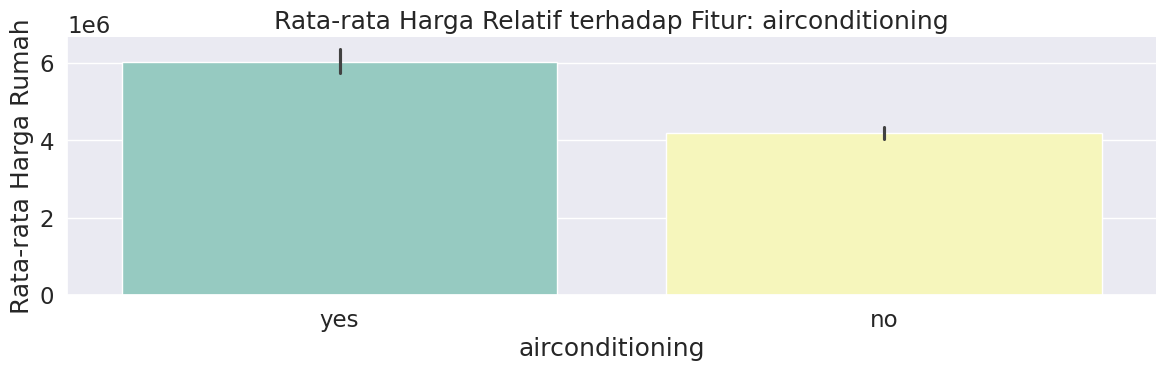

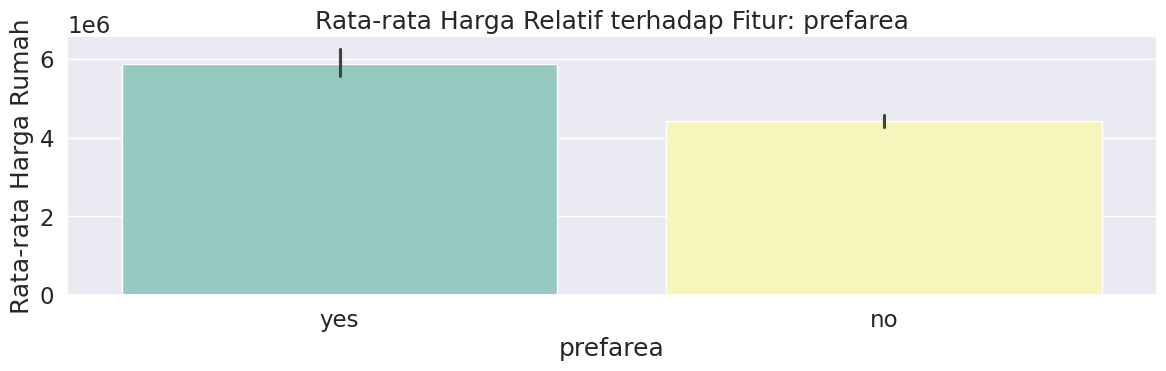

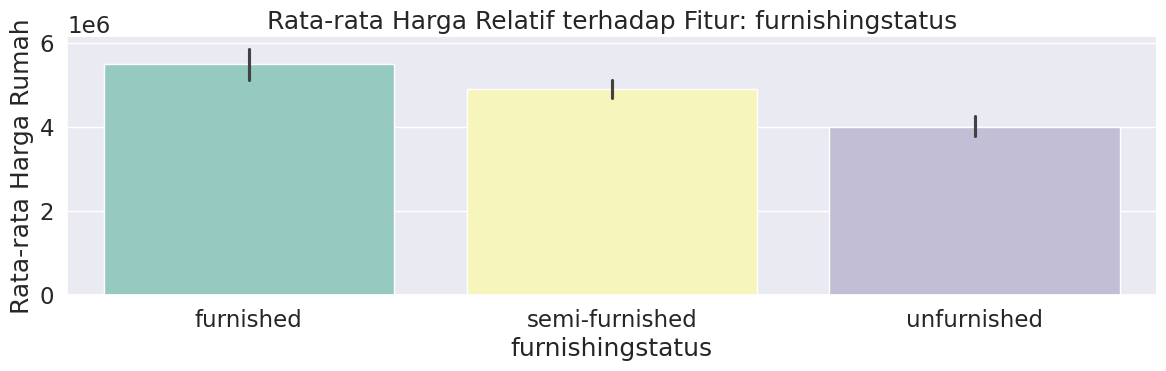

In [180]:
# Mengecek rata-rata harga terhadap masing-masing fitur kategori
cat_features = categorical_features

for col in cat_features:
    sns.catplot(x=col, y="price", kind="bar", dodge=False, height = 4, aspect = 3,  data=data, palette="Set3")
    plt.title(f"Rata-rata Harga Relatif terhadap Fitur: {col}")
    plt.ylabel("Rata-rata Harga Rumah")
    plt.xlabel(col)
    plt.show()


**Kesimpulan:**

Rata-rata rumah memiliki harga yang lebih tinggi ketika memiliki lebih banyak fasilitas, ditandai dengan nilai "yes" pada fitur 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea') atau status furnished pada fitur furningstatus

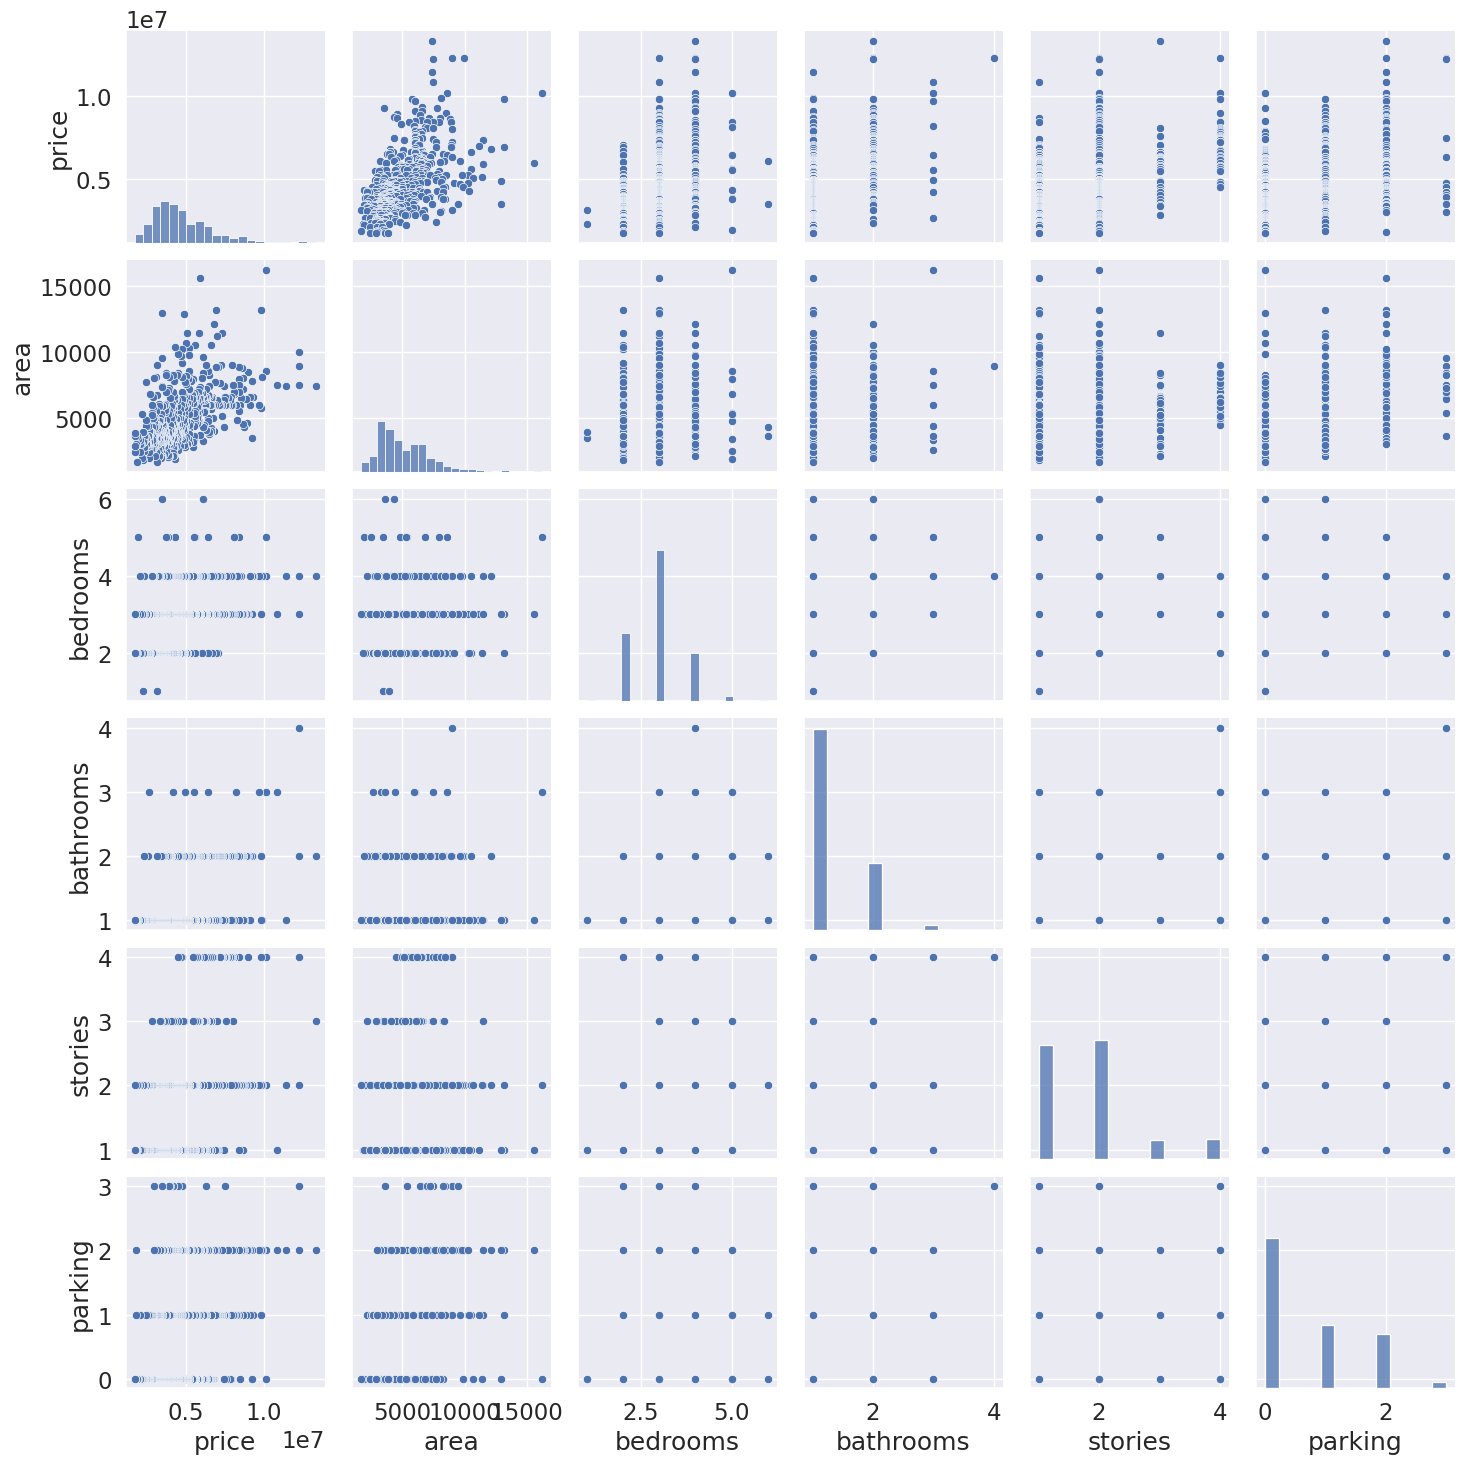

In [181]:
# Mengamati hubungan antar fitur numerik dengan fungsi pairplot()
sns.pairplot(data[numerical_features])
plt.show()

Berdasarkan diagram pairplot, ditemukan bahwa luas bangunan (`area`) memiliki korelasi paling kuat terhadap harga rumah (`price`), di mana semakin besar area rumah, semakin tinggi pula harga jualnya. Selain itu, fitur seperti jumlah kamar tidur (`bedrooms`), kamar mandi (`bathrooms`), jumlah lantai (`stories`), dan kapasitas parkir (`parking`) juga menunjukkan tren peningkatan harga seiring bertambahnya jumlah fasilitas tersebut, meskipun pengaruhnya tidak sekuat area.

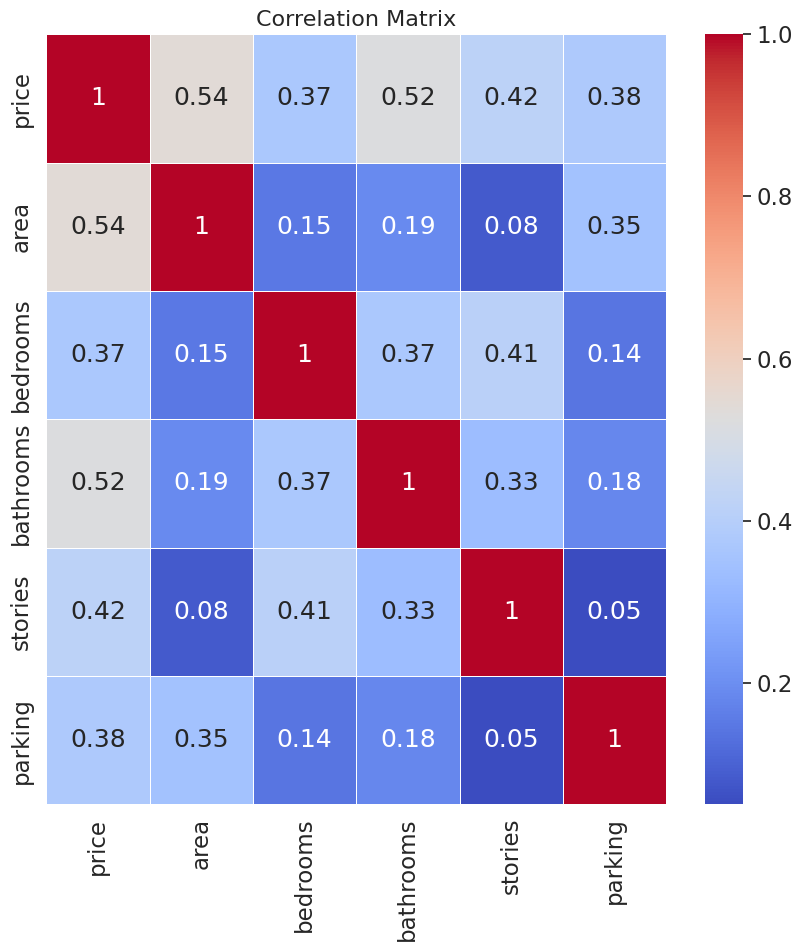

In [182]:
plt.figure(figsize=(10, 10))
correlation_matrix = data[numerical_features].corr().round(2)

sns.heatmap(
    data=correlation_matrix,
    annot=True,
    cmap='coolwarm',
    linewidths=0.5
)
plt.title("Correlation Matrix", size=16)
plt.show()


Berdasarkan matriks korelasi, dapat disimpulkan bahwa harga rumah (`price`) memiliki korelasi paling kuat dengan `area` (0.54) dan `bathrooms` (0.52). Ini menunjukkan bahwa semakin besar luas bangunan dan semakin banyak jumlah kamar mandi, maka cenderung semakin tinggi pula harga rumah. Fitur lain yang juga memiliki korelasi positif meskipun lebih lemah adalah `stories` (0.42), `bedrooms` (0.37), dan `parking` (0.38).

Secara keseluruhan, semua fitur numerik menunjukkan korelasi positif terhadap harga rumah, namun dengan tingkat kekuatan yang bervariasi. Insight ini dapat digunakan sebagai dasar dalam pemilihan fitur untuk model prediktif harga rumah.


# Data Preparation

## Data Encoding

Melakukan konversi nilai kategorikal biner seperti 'yes'/'no' menjadi angka 1/0 pada kolom-kolom: mainroad, guestroom, basement, hotwaterheating, airconditioning, dan prefarea untuk membantu model memahami dalam representasi numerik.

In [183]:
# Label encoding untuk fitur biner
binary_cols = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
le = LabelEncoder()
for col in binary_cols:
    data[col] = le.fit_transform(data[col])

# Ordinal encoding untuk furnishingstatus
furnish_map = {
    'furnished': 1,
    'semi-furnished': 2,
    'unfurnished': 3
}
data['furnishingstatus'] = data['furnishingstatus'].map(furnish_map)


In [184]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1


## Pembagian Dataset

Dataset dibagi menjadi data training dan testing dengan proporsi 80:20. Data training digunakan untuk melatih model agar dapat mempelajari pola dari data sedangkan testing data digunakan untuk mengukur performa model untuk mengevaluasi seberapa baik model dapat melakukan prediksi pada data yang belum pernah dilihat sebelumnya.

In [185]:
# Pembagian Dataset Train Test
from sklearn.model_selection import train_test_split

# Pemisahan fitur target
X = data.drop(columns=['price'])
y = data['price']

# Pembagian data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Standarisasi

Semua fitur numerik diskalakan menggunakan StandardScaler, yaitu mengubah data sehingga memiliki distribusi dengan rata-rata (mean) nol dan standar deviasi satu. Hal ini penting, agar fitur yang memiliki rentang nilai besar tidak mendominasi model.

In [186]:
# Standarisasipake minmax scaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train=y_train.values.reshape(-1,1)
y_test=y_test.values.reshape(-1,1)

y_train_scaled = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)


In [187]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   price             545 non-null    int64
 1   area              545 non-null    int64
 2   bedrooms          545 non-null    int64
 3   bathrooms         545 non-null    int64
 4   stories           545 non-null    int64
 5   mainroad          545 non-null    int64
 6   guestroom         545 non-null    int64
 7   basement          545 non-null    int64
 8   hotwaterheating   545 non-null    int64
 9   airconditioning   545 non-null    int64
 10  parking           545 non-null    int64
 11  prefarea          545 non-null    int64
 12  furnishingstatus  545 non-null    int64
dtypes: int64(13)
memory usage: 55.5 KB


In [188]:
data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1


# Modeling

In [189]:
# Inisialisasi model
models = {
    "Linear Regression": LinearRegression(),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5),
    "SVR (RBF Kernel)": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Evaluasi Model

In [190]:
# Evaluasi model
results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_scaled)
    y_pred = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        "MAE": mae,
        "RMSE": rmse,
        "R2 Score": r2
    }

# Tampilkan hasil evaluasi
pd.DataFrame(results).T.sort_values(by="R2 Score", ascending=False)


,MAE,RMSE,R2 Score
Gradient Boosting,0.091911,0.123993,0.664659
Linear Regression,0.093303,0.126769,0.649475
SVR (RBF Kernel),0.094719,0.127101,0.647635
Random Forest,0.097246,0.133366,0.612041
KNN Regressor,0.105524,0.151542,0.499087


Evaluasi pada model regresi menggunakan metrik MAE, RMSE, dan R² Score.
- MAE (Mean Absolute Error) menunjukkan rata-rata kesalahan absolut antara nilai prediksi dan nilai aktual; apabila MAE rendah, artinya model memiliki kesalahan prediksi yang kecil secara rata-rata.

- RMSE (Root Mean Squared Error) menunjukkan rata-rata kesalahan kuadrat yang diakar, yang lebih sensitif terhadap kesalahan besar (outlier); semakin kecil RMSE, semakin baik akurasi model.

- R² Score mengukur seberapa baik model menjelaskan variasi dari data target; nilai mendekati 1 menunjukkan model sangat baik, sedangkan nilai mendekati atau di bawah 0 menunjukkan model buruk bahkan lebih jelek dari prediksi rata-rata.

Dari tabel yang terlihat menunjukkan bahwa model Gradient Boosting memiliki performa terbaik dengan MAE dan RMSE paling rendah serta R² Score tertinggi. Sebaliknya, SVR (RBF Kernel) memiliki R² Score negatif dan kesalahan terbesar, menandakan model tersebut tidak cocok untuk dataset ini.

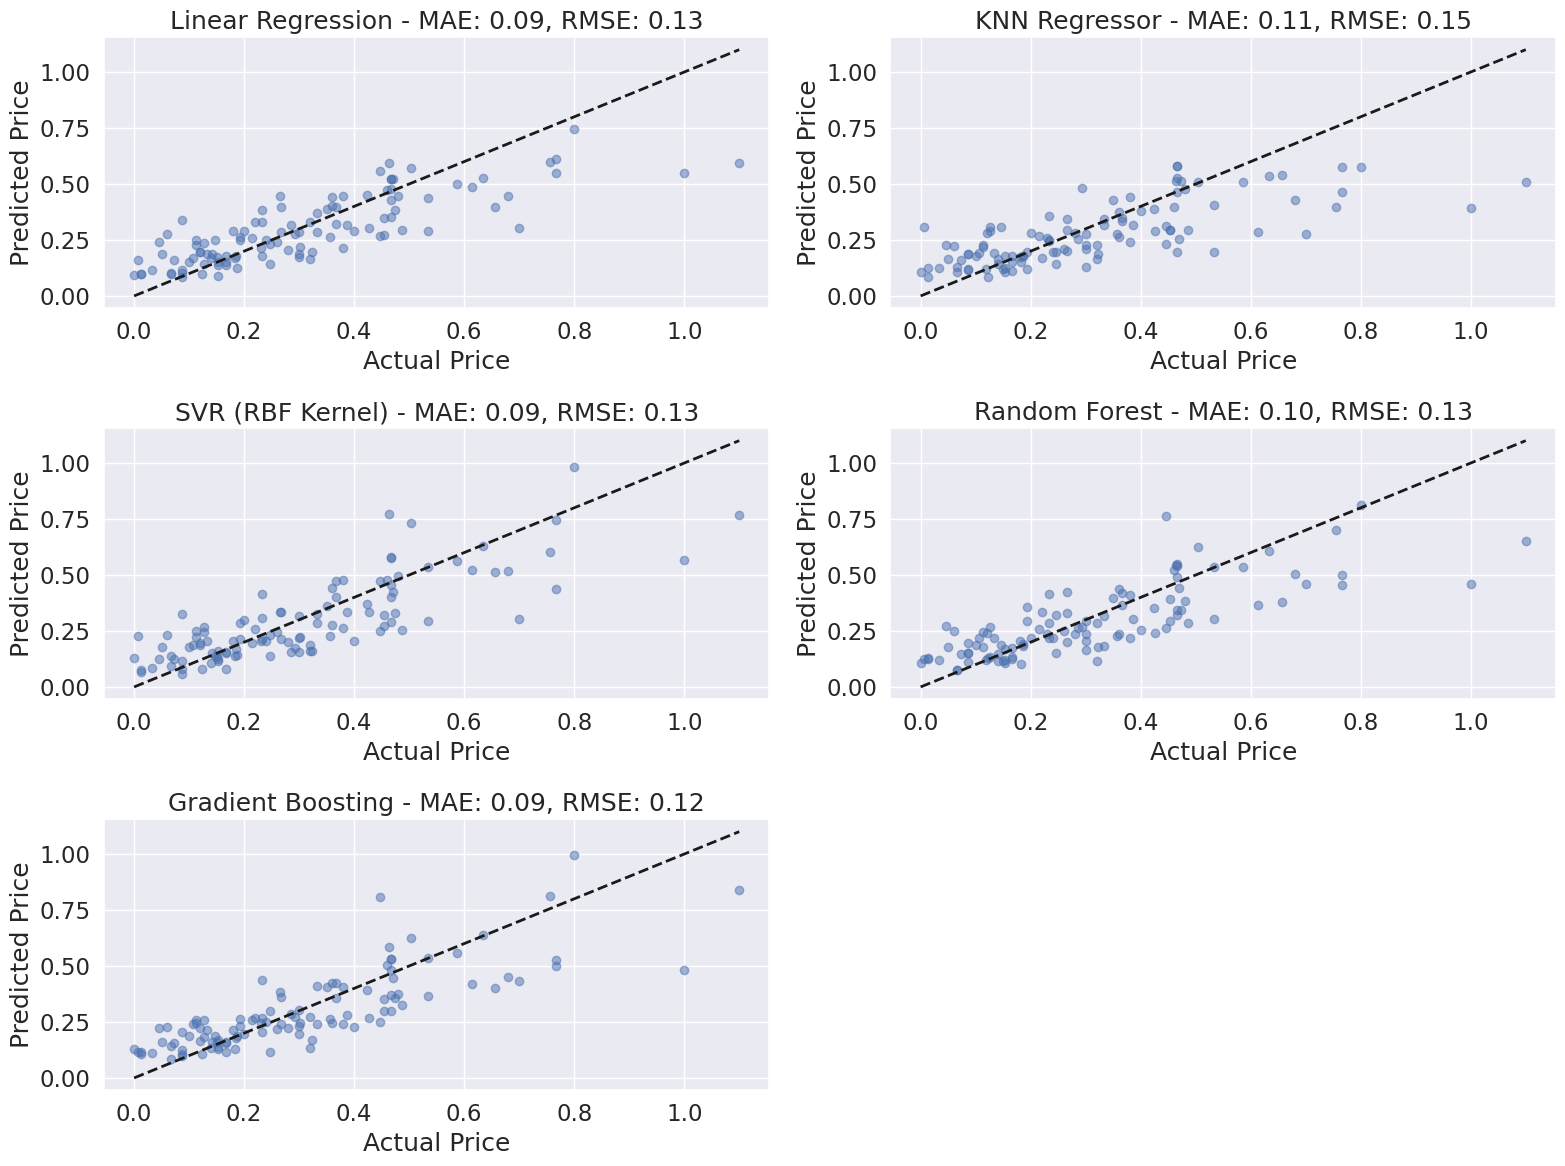

In [192]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 12))

for i, (name, model) in enumerate(models.items(), 1):
    y_pred = model.predict(X_test_scaled)
    plt.subplot(3, 2, i)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.title(f"{name} - MAE: {mean_absolute_error(y_test, y_pred):.2f}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")

plt.tight_layout()
plt.show()


**Kesimpulan:**

Di antara lima model, Gradient Boosting dan Random Forest menunjukkan performa terbaik dalam memprediksi harga, sementara SVR (RBF Kernel) terlihat sebagai model dengan performa terburuk untuk dataset ini.

- Random Forest dan Gradient Boosting memberikan hasil yang paling mendekati garis ideal dibandingkan model lainnya. Titik-titik prediksi tersebar lebih merata di sepanjang garis, menunjukkan bahwa kedua model ini menangkap pola dalam data dengan lebih akurat.
- SVR (RBF Kernel) sebagian besar prediksi stagnan di sekitar satu nilai tertentu (sekitar 5 juta), menunjukkan bahwa model tidak menangkap variasi data dengan baik.

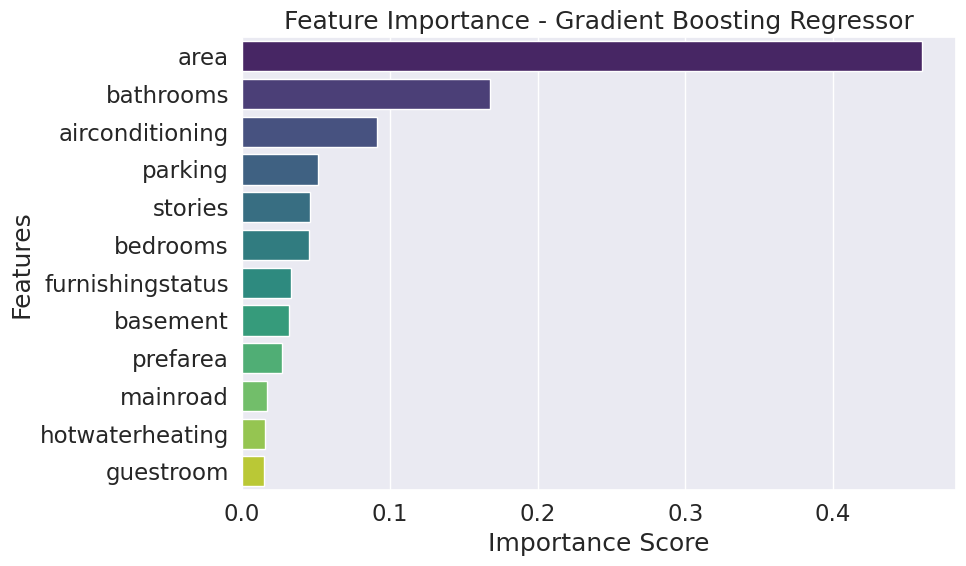

In [196]:
gbr_model = models["Gradient Boosting"]

# Ambil nama fitur dan nilai importance
feature_importance = pd.Series(gbr_model.feature_importances_, index=X_train.columns)

# Urutkan dari yang paling penting
feature_importance = feature_importance.sort_values(ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance, y=feature_importance.index, palette="viridis")
plt.title("Feature Importance - Gradient Boosting Regressor")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

Visualisasi menunjukkan bahwa fitur yang paling memengaruhi prediksi harga rumah area (luas bangunan) dengan skor importance tertinggi (lebih dari 0.4). Semakin luas rumah, semakin tinggi pula prediksinya. Selanjutnya disusul bathrooms (jumlah kamar mandi) yang menunjukkan bahwa kenyamanan fasilitas sangat dipertimbangkan dalam penilaian harga.